In [34]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *     # Import all the preprocessing methods
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, balanced_accuracy_score, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np
import sys, pickle
import shap
from sklearn.model_selection import train_test_split, TimeSeriesSplit
plt.rcParams["figure.figsize"] = (10,7)

import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import RandomOverSampler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [35]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_7kfeats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [65]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [37]:
import pickle
with open("./metadata/top_K_feat_from_7k.pkl", "rb") as f:
    top_k_feats = pickle.load(f)

In [39]:
y_train_class = train_set['Target > 2']
x_train_class = train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Target > 2'], axis=1)
x_train_class = x_train_class[top_k_feats + ['Abs Target']]

In [40]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x_train_class, y_train_class, test_size=0.4, shuffle=False)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_test_class, y_test_class, test_size=0.5, shuffle=False)

In [41]:
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['logloss'],
          'lambda': 1, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2}

In [42]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_class,y_train_class )

In [48]:
weights=X_res[17].apply(lambda x : (2-x)/2 if x<2 else (x-2)/38)
dtrain_class = xgb.DMatrix(X_res.drop(columns=[17]), y_res,weight=weights)
dtrain_class2 = xgb.DMatrix(X_train_class.drop(columns=[17]), y_train_class)
dval_class = xgb.DMatrix(X_val_class.drop(columns=[17]), y_val_class)

In [49]:
clf_class = xgb.train(params,dtrain_class,evals=[(dtrain_class, 'train'),(dval_class, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-logloss:0.65001	test-logloss:0.64874
[1]	train-logloss:0.61082	test-logloss:0.60828
[2]	train-logloss:0.57506	test-logloss:0.57126
[3]	train-logloss:0.54246	test-logloss:0.53727
[4]	train-logloss:0.51265	test-logloss:0.50704
[5]	train-logloss:0.48531	test-logloss:0.47873
[6]	train-logloss:0.46007	test-logloss:0.45244
[7]	train-logloss:0.43673	test-logloss:0.42807
[8]	train-logloss:0.41495	test-logloss:0.40587
[9]	train-logloss:0.39468	test-logloss:0.38501
[10]	train-logloss:0.37591	test-logloss:0.36565
[11]	train-logloss:0.35828	test-logloss:0.34749
[12]	train-logloss:0.34184	test-logloss:0.33059
[13]	train-logloss:0.32639	test-logloss:0.31500
[14]	train-logloss:0.31207	test-logloss:0.30029
[15]	train-logloss:0.29859	test-logloss:0.28648
[16]	train-logloss:0.28619	test-logloss:0.27364
[17]	train-logloss:0.27413	test-logloss:0.26123
[18]	train-logloss:0.26305	test-logloss:0.24992
[19]	train-logloss:0.25245	test-logloss:0.23909
[20]	train-logloss:0.24272	test-logloss:0.22900
[2

In [50]:
y_pred_train_class = clf_class.predict(dtrain_class2)
y_pred_val_class = clf_class.predict(dval_class)

In [52]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_class, y_pred_val_class)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.5433


In [53]:
y_pred_train_class = (y_pred_train_class >= best_threshold).astype(int)
y_pred_val_class = (y_pred_val_class >= best_threshold).astype(int)


In [56]:
cm = confusion_matrix(y_val_class, y_pred_val_class)
cm

array([[5264,   32],
       [  32,  159]], dtype=int64)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

#X_val = X_val.iloc[26:]
#y_val = y_val.iloc[26:]

In [67]:
X_train.columns=train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Abs Target', 'Target > 2'], axis=1).columns
X_val.columns=X_train.columns
X_test.columns=X_train.columns

In [68]:
X_train['Class']=y_pred_train_class
X_val['Class']=y_pred_val_class

In [69]:
def xgb_mape(preds, dtrain):
   labels = dtrain.get_label()
   return('mape', -np.mean(np.abs((labels - preds) / (labels + 1))))

params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

In [72]:
dtrain = xgb.DMatrix(X_train[X_train['Class']==1].drop(columns=['Class']), y_train[X_train['Class']==1])
dval = xgb.DMatrix(X_val[X_val['Class']==1].drop(columns=['Class']), y_val[X_val['Class']==1])

In [73]:
clf = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:17.27074	test-rmse:20.19552
[1]	train-rmse:16.65789	test-rmse:19.47835
[2]	train-rmse:16.04953	test-rmse:18.77623
[3]	train-rmse:15.51477	test-rmse:18.19983
[4]	train-rmse:14.96675	test-rmse:17.54882
[5]	train-rmse:14.49145	test-rmse:16.98556
[6]	train-rmse:14.03890	test-rmse:16.43000
[7]	train-rmse:13.57566	test-rmse:16.02547
[8]	train-rmse:13.14161	test-rmse:15.42524
[9]	train-rmse:12.73918	test-rmse:14.88417
[10]	train-rmse:12.37297	test-rmse:14.45058
[11]	train-rmse:12.03444	test-rmse:14.15751
[12]	train-rmse:11.70951	test-rmse:13.66435
[13]	train-rmse:11.34933	test-rmse:13.17383
[14]	train-rmse:11.02946	test-rmse:12.78455
[15]	train-rmse:10.73725	test-rmse:12.46841
[16]	train-rmse:10.44324	test-rmse:12.08762
[17]	train-rmse:10.15731	test-rmse:11.79245
[18]	train-rmse:9.90587	test-rmse:11.47671
[19]	train-rmse:9.66064	test-rmse:11.20071
[20]	train-rmse:9.39975	test-rmse:10.94675
[21]	train-rmse:9.18875	test-rmse:10.70486
[22]	train-rmse:8.99165	test-rmse:10.53173
[23

In [74]:
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

In [76]:
feat_importance = clf.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = clf.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train[X_train['Class']==1].drop(columns=['Class']))
shap_summary = pd.DataFrame(shap_values.values, columns=X_train[X_train['Class']==1].drop(columns=['Class']).columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

top_K_feat = list(set(top_10_gain+top_10_weight+top_10_shap))

In [77]:
import pickle

In [78]:
with open("./metadata/top_K_feat_from_7k_reg.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

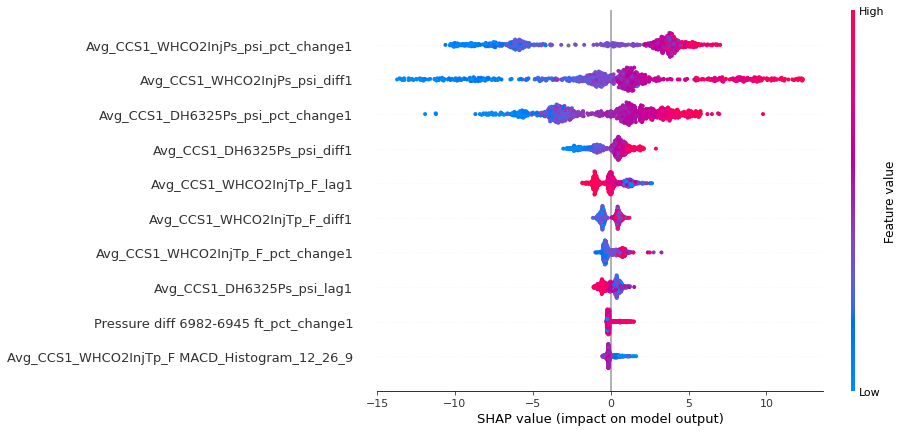

In [80]:
# # Calculate the SHAP values
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer(X_train)

# # Get the top 10 features by absolute SHAP value
# top10_feats = np.sort(shap_values.abs.mean(0).values)[:10]

# # Plot the SHAP summary plot for the top 10 features
shap.summary_plot(shap_values, X_train[X_train['Class']==1].drop(columns=['Class']),
                   plot_size=(10, 7), max_display=10)

In [34]:
shap_values.abs.mean(0)

.values =
array([0.00073046, 0.12607947, 0.00488459, ..., 0.00887969, 0.        ,
       0.        ], dtype=float32)

.base_values =
-3.7998426

.data =
array([2.07793697e+00, 1.17286083e+03, 8.75375574e+01, ...,
       2.67980476e+03, 2.84253300e-02, 7.12585618e+01])

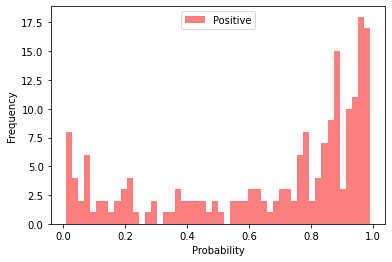

In [14]:
# plot the histogram of probabilities with the color representing the true label
plt.hist(y_pred_val[y_val==1], bins=50, color='r', alpha=0.5, label='Positive')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper center')
plt.show()

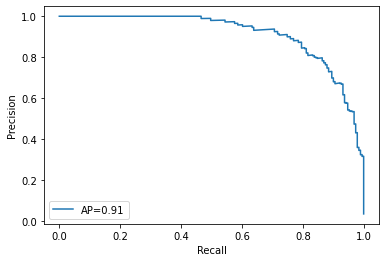

In [16]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
average_precision = average_precision_score(y_val, y_pred_val)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [18]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.3373


In [21]:
# predict binary labels using the best threshold
y_pred = (y_pred_val >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

In [22]:
cm

array([[5248,   22],
       [  39,  152]], dtype=int64)

In [62]:
cm

array([[8732,   23],
       [  38,  269]], dtype=int64)

In [40]:
cm

array([[8722,   33],
       [  34,  273]], dtype=int64)